# Simulation of Sequences

In [1]:
from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import BlackmanWaveform, RampWaveform
from pulser.devices import MockDevice

import numpy as np
import qutip
import matplotlib.pyplot as plt

To illustrate the simulation of sequences, let us study a simple one-dimensional system with periodic boundary conditions (a ring of atoms):

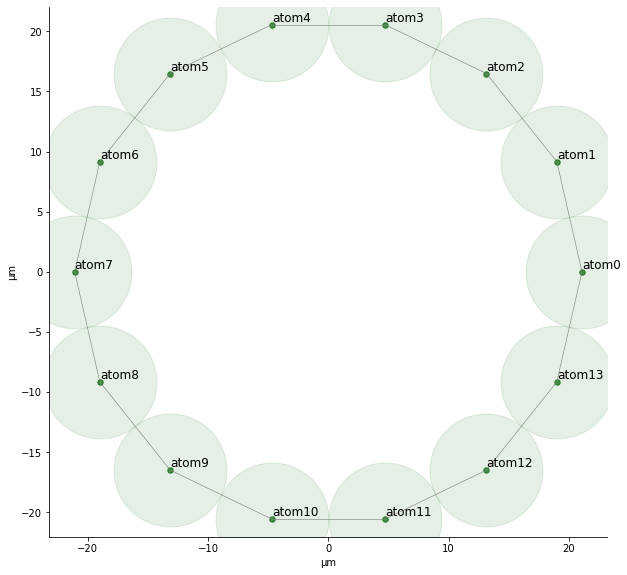

In [4]:
# Setup
L = 14

Omega_max = 2.3 * 2*np.pi 
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 5000

# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = MockDevice.rydberg_blockade_radius(U)
coords = R_interatomic/(2*np.tan(np.pi/L)) * np.array([(np.cos(theta*2*np.pi/L), np.sin(theta*2*np.pi/L)) for theta in range(L)])
                                  
reg = Register.from_coordinates(coords, prefix='atom')

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph = True)

We use the drawing capabilites of the `Register` class to highlight the area **half** the blockade radius away from each atom, which makes it so that overlapping circles correspond to interacting atoms. This is further fleshed out by the graph edges drawn using the `draw_graph` option.

In this register, we shall act with the following pulser sequence, which is designed to reach a state with *antiferromagnetic order*:

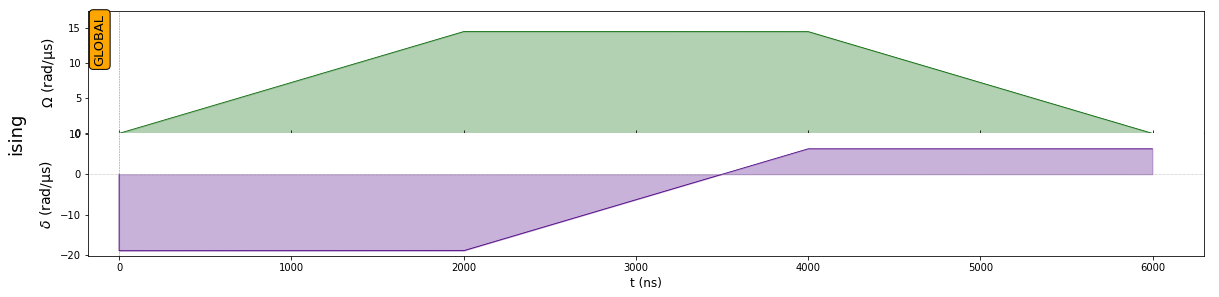

In [3]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

seq.draw()

## 1. Running a Simulation

First we define our `Simulation` object, which creates an internal respresentation of the quantum system, including the Hamiltonian which will drive the evolution:

In [4]:
sim = Simulation(seq, sampling_rate=0.01)

Notice we have included the parameter `sampling_rate` which allows us to determine how many samples from the pulse sequence we wish to simulate. In the case of the simple shapes in our sequence, only a very small fraction is needed. This largely accelerates the simulation time in the solver.

To run the simulation we simply apply the method `run()`. At the time of writing of this notebook, the method uses a series of routines from **QuTiP** for solving the Schröedinger equation of the system. It returns a `SimulationResults` object, which will allow the study or post-processing of the states for each time step in our simulation. Additionally, we can include a progress bar to have an estimate of how the simulation is advancing:

In [5]:
results = sim.run(progress_bar=True)

10.0%. Run time:   0.51s. Est. time left: 00:00:00:04
20.0%. Run time:   1.39s. Est. time left: 00:00:00:05
30.0%. Run time:   2.53s. Est. time left: 00:00:00:05
40.0%. Run time:   3.65s. Est. time left: 00:00:00:05
50.0%. Run time:   4.50s. Est. time left: 00:00:00:04
60.0%. Run time:   5.47s. Est. time left: 00:00:00:03
70.0%. Run time:   6.61s. Est. time left: 00:00:00:02
80.0%. Run time:   7.49s. Est. time left: 00:00:00:01
90.0%. Run time:   8.33s. Est. time left: 00:00:00:00
Total run time:   8.83s


## 2. Using the `SimulationResults` object

The `SimulationResults` object that we created contains the quantum state at each time step. We can call them using the `states` attribute:

In [6]:
results.states[23] # Given as a `qutip.Qobj` object

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-9.57712867103956e-05-0.0002846250699529942j)
  (1, 0)	(-2.3278489711088717e-05-6.584977077472821e-05j)
  (2, 0)	(-2.3278489711088907e-05-6.58497707747284e-05j)
  (3, 0)	(-6.622450614204675e-06-1.799445178927893e-05j)
  (4, 0)	(-2.3278489711088602e-05-6.58497707747282e-05j)
  (5, 0)	(-5.917384421361052e-06-1.625609789577249e-05j)
  (6, 0)	(-6.622450614204703e-06-1.7994451789278624e-05j)
  (7, 0)	(-1.2144349102591239e-06-2.2603542498739613e-06j)
  (8, 0)	(-2.327848971108854e-05-6.584977077472809e-05j)
  (9, 0)	(-5.901588025815514e-06-1.6217726943424873e-05j)
  (10, 0)	(-5.91738442136097e-06-1.6256097895772504e-05j)
  (11, 0)	(-9.026870363555831e-07-1.3821050501422003e-06j)
  (12, 0)	(-6.6224506142048154e-06-1.7994451789278424e-05j)
  (13, 0)	(-9.026870363554389e-07-1.382105050142422e-06j)
  (14, 0)	(-1.214434910258933e-06-2

We can sample the final state directly, using the `sample_final_state()` method from the `SimulationResults` object. We try it with $1000$ samples and discard the less frequent bitstrings:

<BarContainer object of 29 artists>

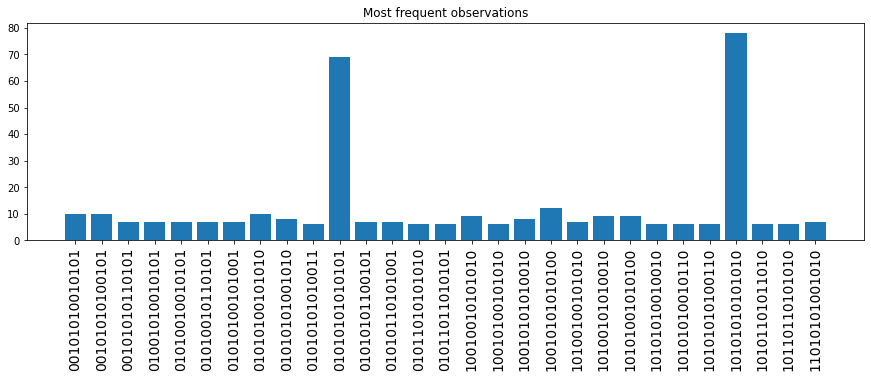

In [7]:
counts = results.sample_final_state(meas_basis='ground-rydberg', N_samples=1000)

large_counts = {k:v for k,v in counts.items() if v > 5}

plt.figure(figsize=(15,4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic order states.

We can also compute the expectation values of operators for the states in the evolution, using the `expect()` method, which takes a list of operators (in this case, the local magnetization acting on the $j$-th spin):

In [8]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)

magn_list = [magnetization(j, L) for j in range(L)]

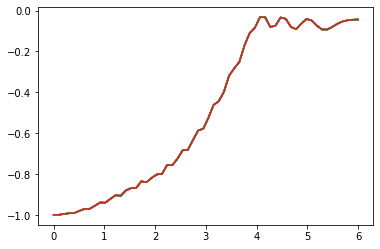

In [9]:
expect_magnetization = results.expect(magn_list)
for data in expect_magnetization:
    plt.plot(sim._times, data)

Notice how the local magnetization on *each* atom goes in the same way from $-1$ (which corresponds to the ground state) to $0$. This is expected since as we saw above, the state after the evolution has antiferromagnetic-order, so at each site, there is a compensation of magnetization. The parity (even) and the boundary conditions (periodic) allow for two lowest-energy states, whose superposition is similar to that of the perfectly antiferromagnetic state:  $\Big(|grgr\cdots \rangle + |rgrg\cdots \rangle\Big)/\sqrt{2}$